# Front Orientation Analysis

This notebook illustrates how to use **FrontTracker** to detect, analyze, and visualize oceanic fronts using a selected subset of labeled structures.  
The labels used here were obtained from the front identification performed in the demo *[Visualizing Labeled Fronts](../visualizing_labeled_fronts/)*.  

In this demo, we will:  
1. **Select specific fronts** by their labels from a pre-identified set of structures.  
2. **Extract metrics** for each front, including `area`, `length`, `width`, `eccentricity`, and probability density descriptors (`kurtosis` and `skewness`).  
3. **Compare orientation effects** by rotating fronts and evaluating whether geometric or statistical descriptors change.  
4. **Visualize results** with two complementary approaches:  
   - *Skeleton plots* to highlight the frontal line.  
   - *Ellipse representation* to summarize `orientation`, `size`, and `eccentricity`.
   - *PDF histograms* to illustrate the distribution of frontal pixels along longitude and latitude.  

This notebook provides a **hands-on example** of how labeled fronts can be isolated, transformed, and analyzed within the FrontTracker workflow, complementing the regional visualization shown in the previous demo.  

In [1]:
# -----------------------------------
# LIBRARY IMPORTS
# -----------------------------------
import copy
import numpy as np
import pandas as pd

import cartopy
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
import matplotlib.gridspec as gridspec

from fronttracker.core import FrontTracker

# -----------------------------------
# LOAD DATA
# -----------------------------------
gm = np.load(".../gm.npy")
latitude = np.load(".../latitude.npy")
longitude = np.load(".../longitude.npy")

# -----------------------------------
# FRONT THRESHOLD
# -----------------------------------
treshold = 0.05

# -----------------------------------
# FRONT IDENTIFICATION AND TRACKING
# -----------------------------------

# Initialize the front tracker
front_tracker = FrontTracker()

# Identify fronts in the GM field using the threshold defined earlier
front_tracker.identify_fronts(np.array(["2003-01-01"]), longitude, latitude, gm, treshold=treshold)

# Retrieve the list of identified fronts for further analysis
fronts = front_tracker.fronts

print("Fronts:", len(front_tracker.fronts))

Fronts: 400


In [2]:
# -----------------------------------
# FRONT SEARCH AND VISUALIZATION TOOLS
# -----------------------------------

# Function to retrieve a front object from the list by its label
def find_front(fronts, label):
    for k in range(len(fronts)):
        if fronts[k].label == label:
            return fronts[k]
    return None

# Function to plot a front with its ellipse, area, length, width, greatest distance, and probability density functions (PDFs)
def plot_front(ax, front, ax_histx, ax_histy, loc="upper left"):
    lonnnn = 2.2/2
    latttt = 2.2/2

    mid_lon = (front.longitude.max()+front.longitude.min())/2
    mid_lat = (front.latitude.max()+front.latitude.min())/2

    unit = r"km$^2$"
    ax.scatter(front.longitude, front.latitude, s=1.5, color='skyblue', alpha=0.75, edgecolor="none", marker="s", label=f"{np.round(front.area,2)} {unit}")

    ax.plot([front.ellipse.centre[0]+front.ellipse.size[1]/2*np.cos(np.radians(front.ellipse.angle+90)), front.ellipse.centre[0]+front.ellipse.size[1]/2*np.cos(np.radians(front.ellipse.angle + 270))],[front.ellipse.centre[1]+front.ellipse.size[1]/2*np.sin(np.radians(front.ellipse.angle+90)), front.ellipse.centre[1]+front.ellipse.size[1]/2*np.sin(np.radians(front.ellipse.angle + 270))], "k-", zorder=101)
    ax.plot([front.ellipse.centre[0],front.ellipse.centre[0]+front.ellipse.size[1]/2*np.cos(np.radians(front.ellipse.angle + 270))],[front.ellipse.centre[1],front.ellipse.centre[1]+front.ellipse.size[1]/2*np.sin(np.radians(front.ellipse.angle + 270))], "k-", zorder=101)
    ax.plot([front.ellipse.centre[0]+front.ellipse.size[0]/2*np.cos(np.radians(front.ellipse.angle)), front.ellipse.centre[0]+front.ellipse.size[0]/2*np.cos(np.radians(front.ellipse.angle + 180))],[front.ellipse.centre[1]+front.ellipse.size[0]/2*np.sin(np.radians(front.ellipse.angle)), front.ellipse.centre[1]+front.ellipse.size[0]/2*np.sin(np.radians(front.ellipse.angle + 180))], "r-", zorder=101)
    ax.plot([front.ellipse.centre[0],front.ellipse.centre[0]+front.ellipse.size[0]/2*np.cos(np.radians(front.ellipse.angle + 180))],[front.ellipse.centre[1],front.ellipse.centre[1]+front.ellipse.size[0]/2*np.sin(np.radians(front.ellipse.angle + 180))], "r-", zorder=101)

    e = front.ellipse.e
    e.set_edgecolor('deeppink')
    e.set_facecolor('none')
    e.set_linewidth(1)
    e.set_zorder(101)
    ax.add_patch(e)

    ax.set_xlim(mid_lon-lonnnn, mid_lon+lonnnn)
    ax.set_ylim(mid_lat-latttt, mid_lat+latttt)

    # Compute the greatest geodesic distance between any two pixels
    distancia, point1, point2 = front.get_greatest_distance()
    ax.plot([point1[0], point2[0]],[point1[1], point2[1]], c="green", ls="--", lw=1)#, label=f"{np.round(distancia,2)} km")

    legend_elements = [
        Patch(facecolor='skyblue', alpha=0.75, label=f"{np.round(front.area,2)} {unit}"),
        Line2D([0], [0], color="r", linestyle='-', label=f"{np.round(front.length,2)} km"),
        Line2D([0], [0], color="k", linestyle='-', label=f"{np.round(front.width,2)} km"),
        Line2D([0], [0], color='green', linestyle='--', lw=1, label=f"{np.round(distancia,2)} km")
    ]

    ax.legend(handles=legend_elements, loc=loc, frameon=False, fontsize=8)

    ax.set_xlabel("Longitude")

    ax_histx.plot(front.ellipse.x_pdf.data_values, front.ellipse.x_pdf.pdf_values)
    ax_histx.fill_between(front.ellipse.x_pdf.data_values, front.ellipse.x_pdf.pdf_values, color='skyblue', alpha=0.5)
    ax_histx.set_ylabel("PDF")
    ax_histx.set_xlim(mid_lon-lonnnn, mid_lon+lonnnn)
    ax_histx.set_xticklabels([])

    ax_histy.plot(front.ellipse.y_pdf.pdf_values, front.ellipse.y_pdf.data_values)
    ax_histy.fill_betweenx(front.ellipse.y_pdf.data_values, front.ellipse.y_pdf.pdf_values, color='skyblue', alpha=0.5)
    ax_histy.set_xlabel("PDF")
    ax_histy.set_ylim(mid_lat-latttt, mid_lat+latttt)
    ax_histy.set_yticklabels([])

# Function to plot the frontal line (skeleton) of a front, along with area, skeleton length, and PDFs
def plot_frontal_line(ax, front, ax_histx, ax_histy):
    lonnnn = 2.2/2
    latttt = 2.2/2

    mid_lon = (front.longitude.max()+front.longitude.min())/2
    mid_lat = (front.latitude.max()+front.latitude.min())/2

    unit = r"km$^2$"

    ax.pcolor(front.skeleton.longitude, front.skeleton.latitude, front.skeleton.grid, cmap=ListedColormap(['skyblue']), alpha=0.75)
    ax.pcolor(front.skeleton.longitude, front.skeleton.latitude, front.skeleton.skeleton, cmap=ListedColormap(['deeppink']))

    ax.set_xlim(mid_lon-lonnnn, mid_lon+lonnnn)
    ax.set_ylim(mid_lat-latttt, mid_lat+latttt)

    legend_elements = [
        Patch(facecolor='skyblue', alpha=0.75, label=f"{np.round(front.area,2)} {unit}"),
        Patch(facecolor='deeppink', label=f"{np.round(front.skeleton.length,2)} km")
    ]

    ax.legend(handles=legend_elements, loc="upper left", frameon=False, fontsize=8)
    ax.set_xlabel("Longitude")

    ax_histx.plot(front.ellipse.x_pdf.data_values, front.ellipse.x_pdf.pdf_values)
    ax_histx.fill_between(front.ellipse.x_pdf.data_values, front.ellipse.x_pdf.pdf_values, color='skyblue', alpha=0.5)
    ax_histx.set_ylabel("PDF")
    ax_histx.set_xlim(mid_lon-lonnnn, mid_lon+lonnnn)
    ax_histx.set_xticklabels([])

    ax_histy.plot(front.ellipse.y_pdf.pdf_values, front.ellipse.y_pdf.data_values)
    ax_histy.fill_betweenx(front.ellipse.y_pdf.data_values, front.ellipse.y_pdf.pdf_values, color='skyblue', alpha=0.5)
    ax_histy.set_xlabel("PDF")
    ax_histy.set_ylim(mid_lat-latttt, mid_lat+latttt)
    ax_histy.set_yticklabels([])

# Function to build a comparative figure:
#  - left panel shows the frontal line (skeleton) of the original front,
#  - right panel shows the ellipse-based visualization of the rotated front
def plot_figure(front_original, front_rotated):
    fig = plt.figure(figsize=(4.8*2, 4.8))
    gs =  fig.add_gridspec(4, 11)
    
    ax = fig.add_subplot(gs[1:,:4])
    ax_histx = fig.add_subplot(gs[0,:4])
    ax_histy = fig.add_subplot(gs[1:,4])
    plot_frontal_line(ax, front_original, ax_histx, ax_histy)
    ax.set_ylabel("Latitude")
    
    ax = fig.add_subplot(gs[1:,6:10])
    ax_histx = fig.add_subplot(gs[0,6:10])
    ax_histy = fig.add_subplot(gs[1:,10])
    plot_front(ax, front_rotated, ax_histx, ax_histy)

In [3]:
# -----------------------------------
# FRONT ANALYSIS: ORIGINAL VS. ROTATED
# -----------------------------------

# Extract a copy of the original front (ID=152) and compute its metrics
print("Original front:")
front_original = copy.deepcopy(find_front(front_tracker.fronts, 152))
front_original.metrics()
description = front_original.get_gm_description()

# Create a rotated copy of the same front, set its orientation angle to 0°, and compute metrics again for comparison
# Note that gradient magnitude (GM) metrics are not modified by rotating the front
print("\nRotated front:")
front_rotated = copy.deepcopy(find_front(front_tracker.fronts, 152))
front_rotated.metrics()
front_rotated.rotate_front(0)
description = front_rotated.get_gm_description()

Original front:
pixels: 668
  mean: 0.0642
   std: 0.0101
   min: 0.0500
   25%: 0.0560
   50%: 0.0622
   75%: 0.0708
   max: 0.0940

Rotated front:
pixels: 668
  mean: 0.0642
   std: 0.0101
   min: 0.0500
   25%: 0.0560
   50%: 0.0622
   75%: 0.0708
   max: 0.0940


,front,angle,eccentricity,x_pdf.kurt,x_pdf.skew,y_pdf.kurt,y_pdf.skew
0,original.152,-173.745448,0.992106,-1.141484,-0.126602,0.237510,-1.042685
1,rotated.152,180.000000,0.992106,-1.125237,0.153830,-0.920644,0.075178


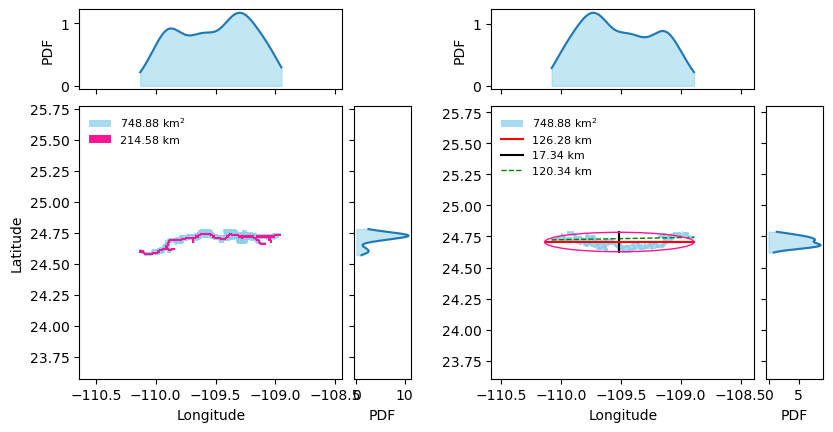

In [4]:
# -----------------------------------
# FRONT COMPARISON: METRICS AND PDFs
# -----------------------------------

# Extract front with ID=152 and compute its metrics (original orientation)
front_original = copy.deepcopy(find_front(front_tracker.fronts, 152))
front_original.metrics()

# Create a copy of the same front, set its orientation angle to 0°, and compute its metrics
# Note: although 0° and 180° describe the same major axis of the ellipse, they produce different pixel configurations
front_rotated = copy.deepcopy(find_front(front_tracker.fronts, 152))
front_rotated.metrics()
front_rotated.rotate_front(0)

# Generate comparative figure
plot_figure(front_original, front_rotated)

# Build a DataFrame summarizing angle, eccentricity, and PDF descriptors (kurtosis and skewness) for the original vs. rotated front
pd.DataFrame([
    ["original.152", front_original.ellipse.angle, front_original.ellipse.eccentricity, front_original.ellipse.x_pdf.kurt, front_original.ellipse.x_pdf.skew, front_original.ellipse.y_pdf.kurt, front_original.ellipse.y_pdf.skew],
    ["rotated.152", front_rotated.ellipse.angle, front_rotated.ellipse.eccentricity, front_rotated.ellipse.x_pdf.kurt, front_rotated.ellipse.x_pdf.skew, front_rotated.ellipse.y_pdf.kurt, front_rotated.ellipse.y_pdf.skew]
], columns=["front","angle","eccentricity","x_pdf.kurt","x_pdf.skew","y_pdf.kurt","y_pdf.skew"])

,front,angle,eccentricity,x_pdf.kurt,x_pdf.skew,y_pdf.kurt,y_pdf.skew
0,original.113,132.35617,0.980046,-1.060180,0.281772,-0.737975,0.475645
1,rotated.113,180.00000,0.980046,-1.096979,0.108999,-0.614052,-0.415137


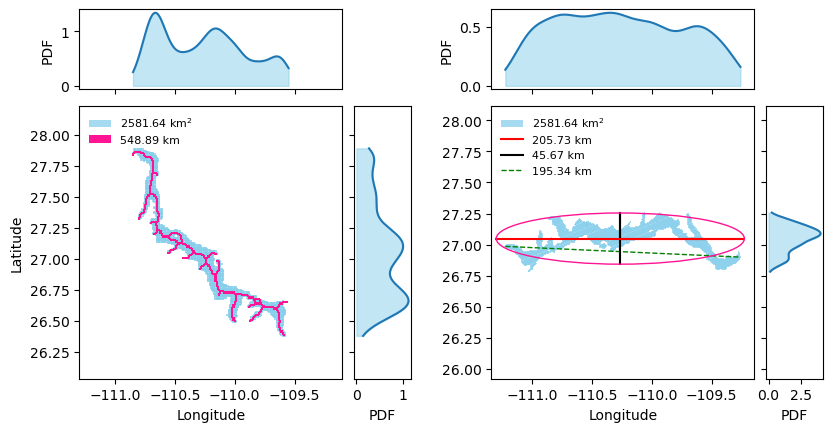

In [5]:
# -----------------------------------
# FRONT COMPARISON: METRICS AND PDFs
# -----------------------------------

# Extract front with ID=113 and compute its metrics (original orientation)
front_original = copy.deepcopy(find_front(front_tracker.fronts, 113))
front_original.metrics()

# Create a copy of the same front, set its orientation angle to 0°, and compute its metrics
front_rotated = copy.deepcopy(find_front(front_tracker.fronts, 113))
front_rotated.metrics()
front_rotated.rotate_front(0)

# Generate comparative figure
plot_figure(front_original, front_rotated)

# Build a DataFrame summarizing angle, eccentricity, and PDF descriptors (kurtosis and skewness) for the original vs. rotated front
pd.DataFrame([
    ["original.113", front_original.ellipse.angle, front_original.ellipse.eccentricity, front_original.ellipse.x_pdf.kurt, front_original.ellipse.x_pdf.skew, front_original.ellipse.y_pdf.kurt, front_original.ellipse.y_pdf.skew],
    ["rotated.113", front_rotated.ellipse.angle, front_rotated.ellipse.eccentricity, front_rotated.ellipse.x_pdf.kurt, front_rotated.ellipse.x_pdf.skew, front_rotated.ellipse.y_pdf.kurt, front_rotated.ellipse.y_pdf.skew]
], columns=["front","angle","eccentricity","x_pdf.kurt","x_pdf.skew","y_pdf.kurt","y_pdf.skew"])

,front,angle,eccentricity,x_pdf.kurt,x_pdf.skew,y_pdf.kurt,y_pdf.skew
0,original.192,-154.924509,0.951931,-1.071843,0.091790,-0.566626,-0.353481
1,rotated.192,180.000000,0.951931,-1.115291,0.125905,-0.863296,0.054145


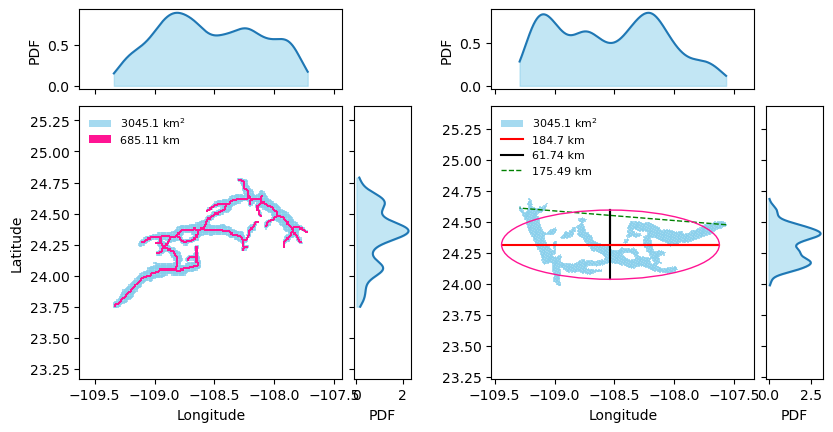

In [6]:
# -----------------------------------
# FRONT COMPARISON: METRICS AND PDFs
# -----------------------------------

# Extract front with ID=192 and compute its metrics (original orientation)
front_original = copy.deepcopy(find_front(front_tracker.fronts, 192))
front_original.metrics()

# Create a copy of the same front, set its orientation angle to 0°, and compute its metrics
front_rotated = copy.deepcopy(find_front(front_tracker.fronts, 192))
front_rotated.metrics()
front_rotated.rotate_front(0)

# Generate comparative figure
plot_figure(front_original, front_rotated)

# Build a DataFrame summarizing angle, eccentricity, and PDF descriptors (kurtosis and skewness) for the original vs. rotated front
pd.DataFrame([
    ["original.192", front_original.ellipse.angle, front_original.ellipse.eccentricity, front_original.ellipse.x_pdf.kurt, front_original.ellipse.x_pdf.skew, front_original.ellipse.y_pdf.kurt, front_original.ellipse.y_pdf.skew],
    ["rotated.192", front_rotated.ellipse.angle, front_rotated.ellipse.eccentricity, front_rotated.ellipse.x_pdf.kurt, front_rotated.ellipse.x_pdf.skew, front_rotated.ellipse.y_pdf.kurt, front_rotated.ellipse.y_pdf.skew]
], columns=["front","angle","eccentricity","x_pdf.kurt","x_pdf.skew","y_pdf.kurt","y_pdf.skew"])

,front,angle,eccentricity,x_pdf.kurt,x_pdf.skew,y_pdf.kurt,y_pdf.skew
0,original.12,159.698389,0.823129,-1.178269,0.099490,-0.469935,0.260400
1,rotated.12,180.000000,0.823129,-1.216976,0.104788,-0.827229,-0.096608


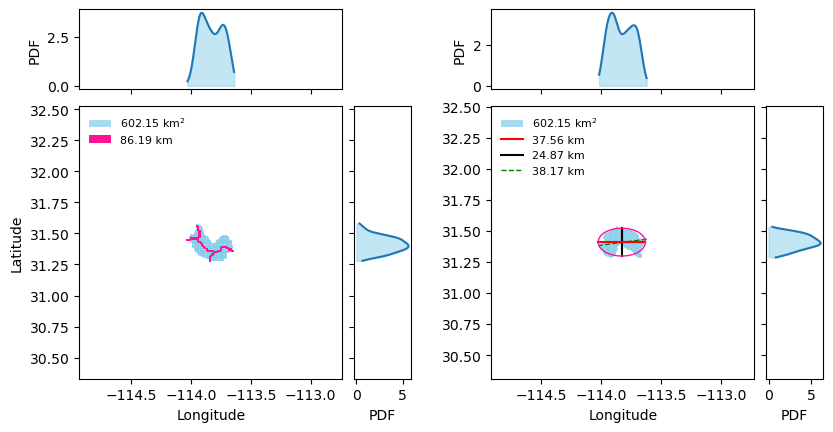

In [7]:
# -----------------------------------
# FRONT COMPARISON: METRICS AND PDFs
# -----------------------------------

# Extract front with ID=12 and compute its metrics (original orientation)
front_original = copy.deepcopy(find_front(front_tracker.fronts, 12))
front_original.metrics()

# Create a copy of the same front, set its orientation angle to 0°, and compute its metrics
front_rotated = copy.deepcopy(find_front(front_tracker.fronts, 12))
front_rotated.metrics()
front_rotated.rotate_front(0)

# Generate comparative figure
plot_figure(front_original, front_rotated)

# Build a DataFrame summarizing angle, eccentricity, and PDF descriptors (kurtosis and skewness) for the original vs. rotated front
pd.DataFrame([
    ["original.12", front_original.ellipse.angle, front_original.ellipse.eccentricity, front_original.ellipse.x_pdf.kurt, front_original.ellipse.x_pdf.skew, front_original.ellipse.y_pdf.kurt, front_original.ellipse.y_pdf.skew],
    ["rotated.12", front_rotated.ellipse.angle, front_rotated.ellipse.eccentricity, front_rotated.ellipse.x_pdf.kurt, front_rotated.ellipse.x_pdf.skew, front_rotated.ellipse.y_pdf.kurt, front_rotated.ellipse.y_pdf.skew]
], columns=["front","angle","eccentricity","x_pdf.kurt","x_pdf.skew","y_pdf.kurt","y_pdf.skew"])

,front,angle,eccentricity,x_pdf.kurt,x_pdf.skew,y_pdf.kurt,y_pdf.skew
0,original.109,157.984045,0.841365,-0.866504,-0.412953,-0.595972,0.479182
1,rotated.109,-180.000000,0.841365,-0.498838,0.852889,0.071083,-0.910709


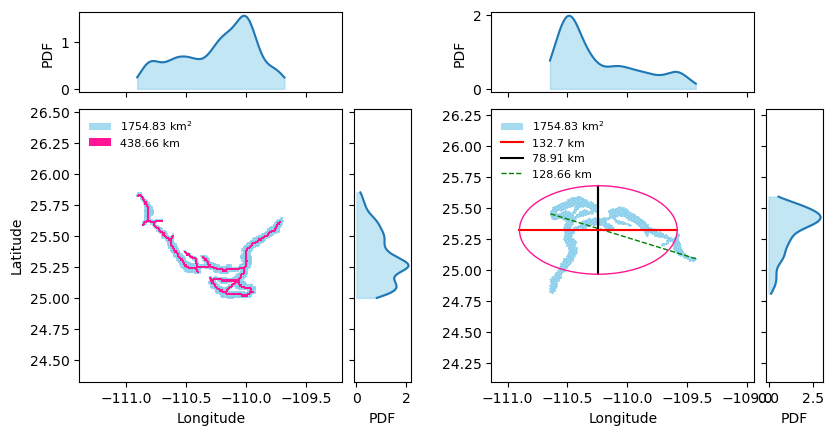

In [8]:
# -----------------------------------
# FRONT COMPARISON: METRICS AND PDFs
# -----------------------------------

# Extract front with ID=109 and compute its metrics (original orientation)
front_original = copy.deepcopy(find_front(front_tracker.fronts, 109))
front_original.metrics()

# Create a copy of the same front, set its orientation angle to 0°, and compute its metrics
front_rotated = copy.deepcopy(find_front(front_tracker.fronts, 109))
front_rotated.metrics()
front_rotated.rotate_front(0)

# Generate comparative figure
plot_figure(front_original, front_rotated)

# Build a DataFrame summarizing angle, eccentricity, and PDF descriptors (kurtosis and skewness) for the original vs. rotated front
pd.DataFrame([
    ["original.109", front_original.ellipse.angle, front_original.ellipse.eccentricity, front_original.ellipse.x_pdf.kurt, front_original.ellipse.x_pdf.skew, front_original.ellipse.y_pdf.kurt, front_original.ellipse.y_pdf.skew],
    ["rotated.109", front_rotated.ellipse.angle, front_rotated.ellipse.eccentricity, front_rotated.ellipse.x_pdf.kurt, front_rotated.ellipse.x_pdf.skew, front_rotated.ellipse.y_pdf.kurt, front_rotated.ellipse.y_pdf.skew]
], columns=["front","angle","eccentricity","x_pdf.kurt","x_pdf.skew","y_pdf.kurt","y_pdf.skew"])

,front,angle,eccentricity,x_pdf.kurt,x_pdf.skew,y_pdf.kurt,y_pdf.skew
0,original.33,158.434594,0.948711,-1.008234,0.105207,-0.643529,-0.375648
1,rotated.33,-180.000000,0.948711,-1.048810,-0.255994,-0.728720,-0.138395


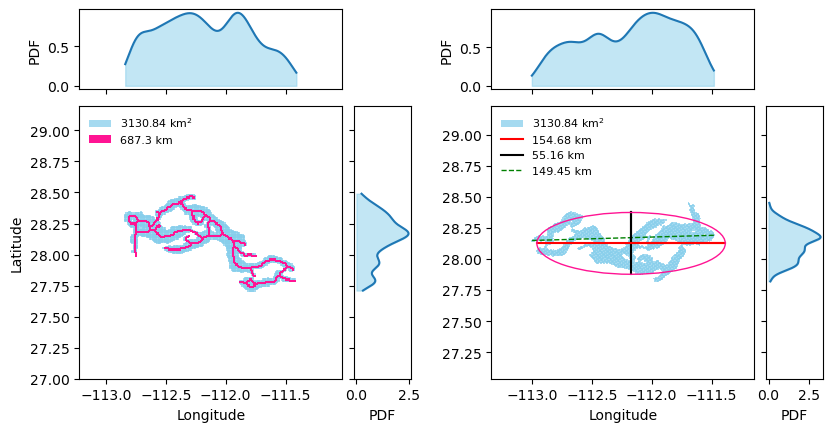

In [9]:
# -----------------------------------
# FRONT COMPARISON: METRICS AND PDFs
# -----------------------------------

# Extract front with ID=33 and compute its metrics (original orientation)
front_original = copy.deepcopy(find_front(front_tracker.fronts, 33))
front_original.metrics()

# Create a copy of the same front, set its orientation angle to 0°, and compute its metrics
front_rotated = copy.deepcopy(find_front(front_tracker.fronts, 33))
front_rotated.metrics()
front_rotated.rotate_front(0)

# Generate comparative figure
plot_figure(front_original, front_rotated)

# Build a DataFrame summarizing angle, eccentricity, and PDF descriptors (kurtosis and skewness) for the original vs. rotated front
pd.DataFrame([
    ["original.33", front_original.ellipse.angle, front_original.ellipse.eccentricity, front_original.ellipse.x_pdf.kurt, front_original.ellipse.x_pdf.skew, front_original.ellipse.y_pdf.kurt, front_original.ellipse.y_pdf.skew],
    ["rotated.33", front_rotated.ellipse.angle, front_rotated.ellipse.eccentricity, front_rotated.ellipse.x_pdf.kurt, front_rotated.ellipse.x_pdf.skew, front_rotated.ellipse.y_pdf.kurt, front_rotated.ellipse.y_pdf.skew]
], columns=["front","angle","eccentricity","x_pdf.kurt","x_pdf.skew","y_pdf.kurt","y_pdf.skew"])